In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve, classification_report
import matplotlib.ticker as mtick
import os

## Background

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it).
The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.
This challenge is significantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges.

## Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:  
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate

## Data

Columns:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
    * Ads: came to the site by clicking on an advertisement
    * Seo: came to the site by clicking on search results
    * Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

## Solution

### First Step: Load and Inspect Data

In [45]:
df=pd.read_csv('conversion_data.csv')

In [46]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [47]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


#### Missing value and Outliers

From the description above, we can find that the age has a maximum as 123 which is abnormal. Let's check the missing value and outliers first.

In [48]:
print(df.isnull().any())

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool


In [49]:
df[df['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [50]:
df=df[df['age']<=100]
df.shape

(316198, 6)

Based on the output above, there is no missing value in this dataset and there are only two records with an age greater than 100. Since the dataset has 316,200 records in total, removing these two records won't cause a great difference. I removed these two record from the datasset.

### Exploratory Data Analysis

#### Country

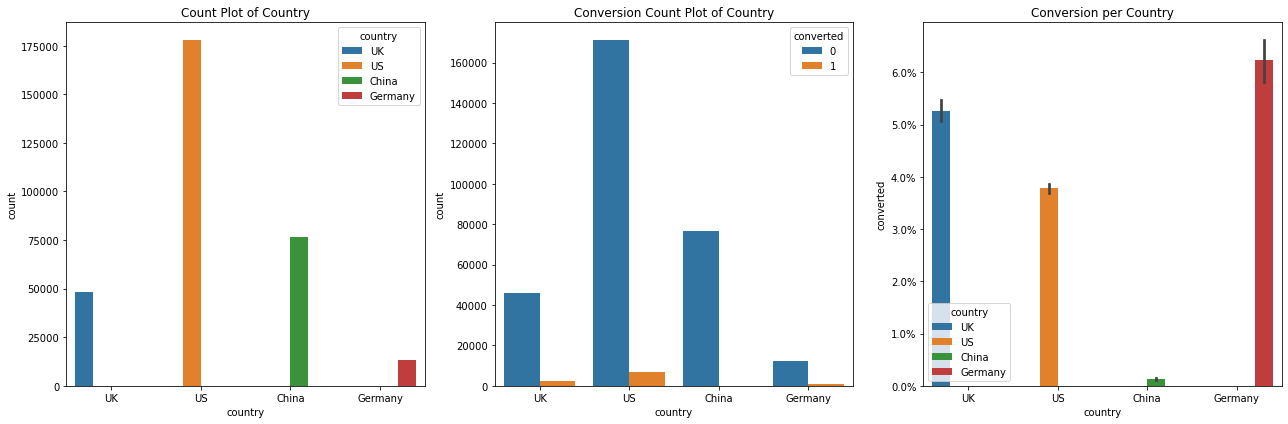

In [51]:
fig, axes= plt.subplots(nrows=1,ncols=3,figsize=(18,6))
sns.countplot(x='country',hue='country',data=df,ax=axes[0])
axes[0].set_title('Count Plot of Country', fontsize=12)
sns.countplot(x='country',hue='converted',data=df,ax=axes[1])
axes[1].set_title('Conversion Count Plot of Country', fontsize=12)
sns.barplot(x='country',y='converted',hue='country',data=df,ax=axes[2])
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[2].set_title('Conversion per Country',fontsize=12)
plt.tight_layout()
plt.show()

#### UserType

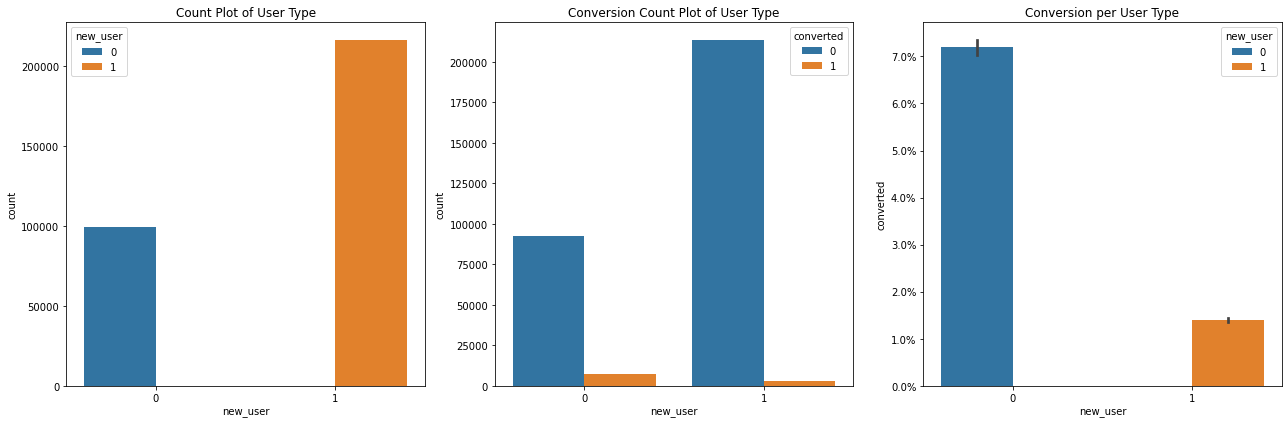

In [52]:
fig, axes= plt.subplots(nrows=1,ncols=3,figsize=(18,6))
sns.countplot(x='new_user',hue='new_user',data=df,ax=axes[0])
axes[0].set_title('Count Plot of User Type', fontsize=12)
sns.countplot(x='new_user',hue='converted',data=df,ax=axes[1])
axes[1].set_title('Conversion Count Plot of User Type', fontsize=12)
sns.barplot(x='new_user',y='converted',hue='new_user',data=df,ax=axes[2])
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[2].set_title('Conversion per User Type',fontsize=12)
plt.tight_layout()
plt.show()

#### Source

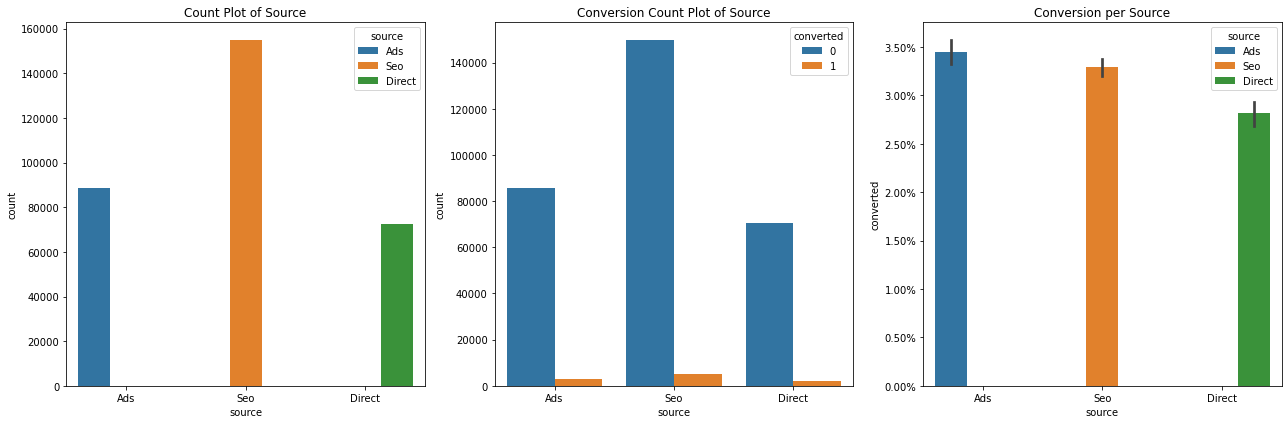

In [53]:
fig, axes= plt.subplots(nrows=1,ncols=3,figsize=(18,6))
sns.countplot(x='source',hue='source',data=df,ax=axes[0])
axes[0].set_title('Count Plot of Source', fontsize=12)
sns.countplot(x='source',hue='converted',data=df,ax=axes[1])
axes[1].set_title('Conversion Count Plot of Source', fontsize=12)
sns.barplot(x='source',y='converted',hue='source',data=df,ax=axes[2])
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[2].set_title('Conversion per Source',fontsize=12)
plt.tight_layout()
plt.show()

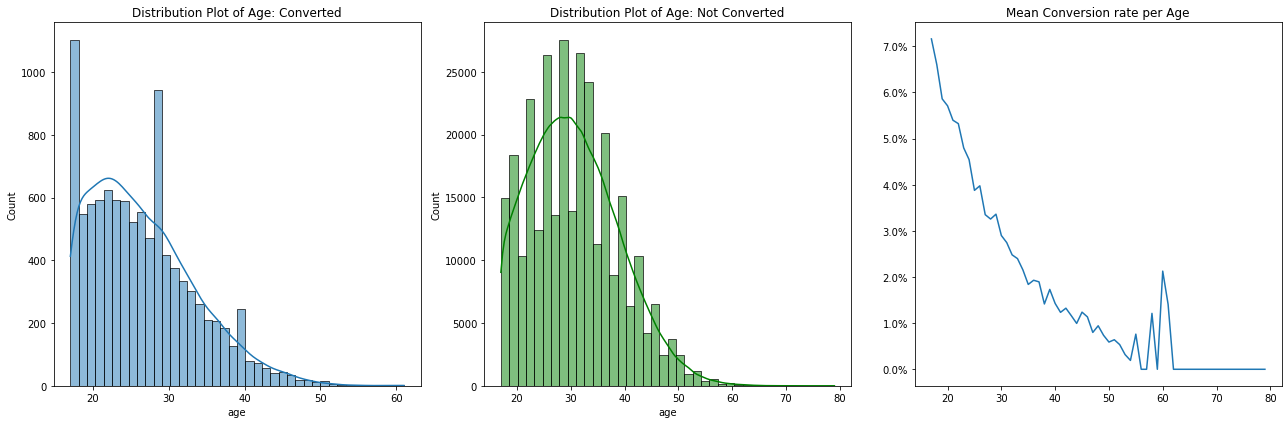

In [54]:
fig, axes= plt.subplots(1,3,figsize=(18,6))
sns.histplot(x='age',data=df[df['converted']==1],ax=axes[0],kde=True,bins=40)
axes[0].set_title('Distribution Plot of Age: Converted', fontsize=12)
sns.histplot(x='age',data=df[df['converted']==0],kde=True,ax=axes[1],bins=40,color='green')
axes[1].set_title('Distribution Plot of Age: Not Converted', fontsize=12)
grouped =df[['age','converted']].groupby('age').mean().reset_index()
axes[2].plot(grouped['age'],grouped['converted'])
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[2].set_title('Mean Conversion rate per Age',fontsize=12)
plt.tight_layout()
plt.show()

#### total_pages_visited

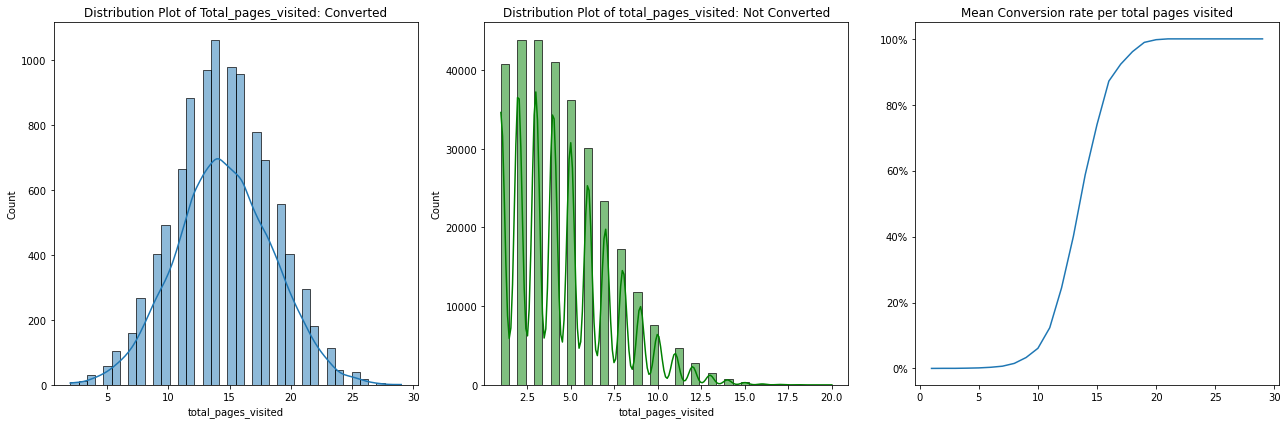

In [108]:
fig, axes= plt.subplots(1,3,figsize=(18,6))
sns.histplot(x='total_pages_visited',data=df[df['converted']==1],ax=axes[0],kde=True,bins=40)
axes[0].set_title('Distribution Plot of Total_pages_visited: Converted', fontsize=12)
sns.histplot(x='total_pages_visited',data=df[df['converted']==0],kde=True,ax=axes[1],bins=40,color='green')
axes[1].set_title('Distribution Plot of total_pages_visited: Not Converted', fontsize=12)
grouped =df[['converted','total_pages_visited']].groupby('total_pages_visited').mean().reset_index()
axes[2].plot(grouped['total_pages_visited'],grouped['converted'])
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axes[2].set_title('Mean Conversion rate per total pages visited',fontsize=12)
plt.tight_layout()
plt.show()

### Classify via Logistic Regression

I decide to address this classification problem with logistic regression. In this project, I used logisticRegressionCV

In [56]:
from sklearn.linear_model import LogisticRegressionCV

<AxesSubplot:>

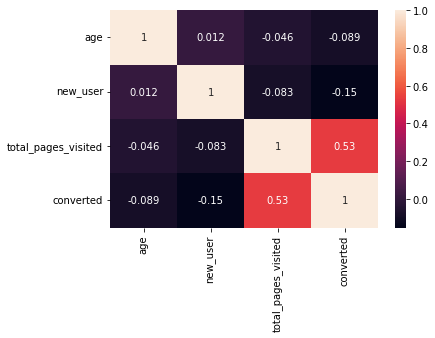

In [57]:
sns.heatmap(df.corr(),annot=True)

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix

Convert categorial variables into dummies.

In [94]:
y=df['converted']
X=df.drop('converted',axis=1)
X= pd.get_dummies(X)
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
scaler=StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [111]:
LogReg = LogisticRegression()
LogReg.fit(scaled_X_train,y_train)

LogisticRegression()

In [117]:
np.round(LogReg.coef_,3)

array([[-0.616, -0.804,  2.536, -1.029,  0.292,  0.46 ,  0.439,  0.02 ,
        -0.054,  0.027]])

In [118]:
LogReg.intercept_

array([-7.61158492])

### Conversion Rate Expression

log(P/(1-p))= -7.612 -0.616*Age -0.804 * New_user + 2.546 * total_pages_visited -1.029 * I(Country=China)+0.292 * I(Country=Germany) + 0.46 * I(Country=UK)+0.439 * I(Country=US)+0.02 *I(Source=Ads)-0.054 * (Source=Direct)+0.027 * I(Source=Seo)

In [86]:
y_pred_train = LogReg.predict(scaled_X_train)
train_accuracy=np.round(accuracy_score(y_train,y_pred_train),4)*100
print("Training set's accuracy is {}%".format(train_accuracy))

Training set's accuracy is 98.61%


In [88]:
y_pred = LogReg.predict(scaled_X_test)
test_accuracy = np.round(accuracy_score(y_test,y_pred),4)*100
print("Testing set's accuracy is {}%".format(test_accuracy))

Testing set's accuracy is 98.67%


#### Confusion Matrix

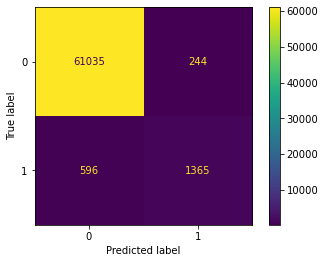

In [98]:
plot_confusion_matrix(LogReg,scaled_X_test,y_test)

#### Scaled so highest value=1

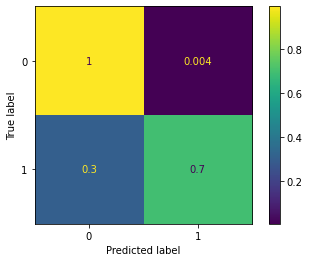

In [101]:
plot_confusion_matrix(LogReg,scaled_X_test,y_test,normalize='true')

#### Classification report

In [93]:
print(classification_report(y_test,y_pred))
classification_report

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61279
           1       0.85      0.70      0.76      1961

    accuracy                           0.99     63240
   macro avg       0.92      0.85      0.88     63240
weighted avg       0.99      0.99      0.99     63240



### Evaluating Curves and AUC

In [104]:
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,plot_roc_curve

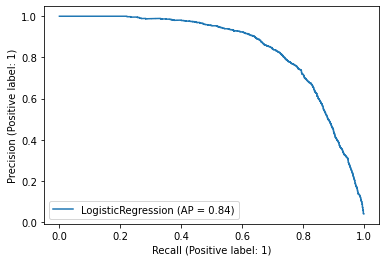

In [105]:
plot_precision_recall_curve(LogReg,scaled_X_test,y_test)

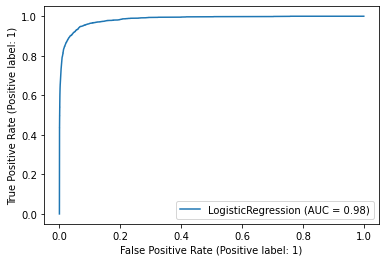

In [107]:
plot_roc_curve(LogReg,scaled_X_test,y_test)

### Recommendation

From the explanatory data analysis and logistic regression, we can find:
* Young peole are more easily to be converted than the older. The marketing team can target young people to design their webstie.
* The more pages people visited, the more likely they convert.
* People from China are less likely to convert than people from other countries. If the team want to target China's market, it's better to conduct a market research to design contents to meet the demand of the young generation in China.
* The result shows that the source isn't a significant variable affecting the conversion rate.